In [6]:
pip install librosa


Note: you may need to restart the kernel to use updated packages.


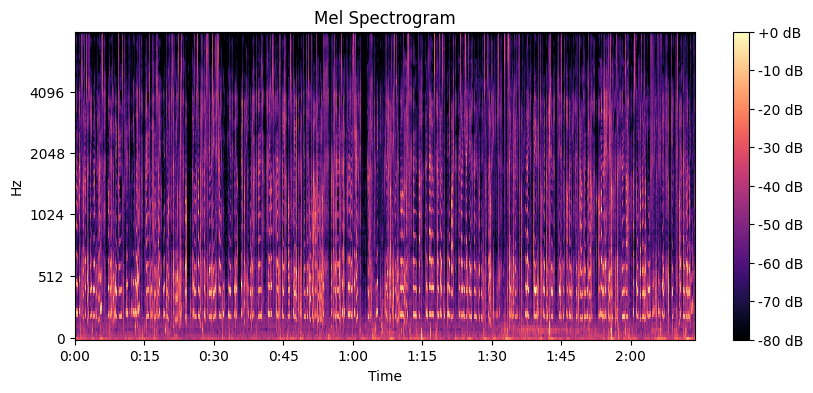

In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

# Folder containing converted .wav files
folder_path = r"C:\Users\chidr\OneDrive\Documents\SEMESTER_6\NLP\STUTTER"

# Get all .wav files
wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]

def audio_to_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Process first file
spectrogram = audio_to_spectrogram(wav_files[0])

# Plot spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()


In [8]:
pip install torchaudio


Note: you may need to restart the kernel to use updated packages.


configuration

In [9]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import torchaudio
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Configuration
SAMPLE_RATE = 16000
N_MELS = 128
MAX_LENGTH = 500
BATCH_SIZE = 8
EPOCHS = 30  # Increased epochs
LEARNING_RATE = 0.0005  # Adjusted learning rate
WEIGHT_DECAY = 1e-4  # Added weight decay for regularization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


FEATURE EXTRACTION & DATE AUGMENTATION


In [10]:
# Improved Feature Extraction
def extract_features(file_path):
    """Extract multiple audio features for better representation"""
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # 1. Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 2. MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    # 3. Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    # 4. Chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # 5. Tempo and beat features
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    tempo_feature = np.array([[tempo]])
    
    # Pad or truncate to MAX_LENGTH
    def pad_or_truncate(feature, target_length=MAX_LENGTH):
        if feature.shape[1] > target_length:
            return feature[:, :target_length]
        else:
            padding = np.zeros((feature.shape[0], target_length - feature.shape[1]))
            return np.concatenate([feature, padding], axis=1)
    
    mel_spec_db = pad_or_truncate(mel_spec_db)
    mfcc = pad_or_truncate(mfcc)
    contrast = pad_or_truncate(contrast)
    chroma = pad_or_truncate(chroma)
    
    # Stack all features
    features = np.concatenate([
        mel_spec_db,  # (128, MAX_LENGTH)
        mfcc,         # (20, MAX_LENGTH)
        contrast,     # (7, MAX_LENGTH)
        chroma        # (12, MAX_LENGTH)
    ], axis=0)  # (167, MAX_LENGTH)
    
    return features, y, sr

# Data Augmentation
class AudioAugmenter:
    def __init__(self, sr=SAMPLE_RATE):
        self.sr = sr
    
    def time_stretch(self, y, rate=None):
        """Time stretch an audio signal by a fixed rate"""
        if rate is None:
            rate = np.random.uniform(0.8, 1.2)  # Random stretch between 0.8x and 1.2x
        return librosa.effects.time_stretch(y, rate=rate)
    
    def pitch_shift(self, y, steps=None):
        """Pitch shift the audio by n semitones"""
        if steps is None:
            steps = np.random.uniform(-3, 3)  # Random pitch shift between -3 and 3 semitones
        return librosa.effects.pitch_shift(y, sr=self.sr, n_steps=steps)
    
    def add_noise(self, y, noise_factor=None):
        """Add random noise to the audio"""
        if noise_factor is None:
            noise_factor = np.random.uniform(0.001, 0.01)
        noise = np.random.randn(len(y))
        return y + noise_factor * noise
    
    def random_augment(self, y):
        """Apply random augmentations"""
        augmentations = [self.time_stretch, self.pitch_shift, self.add_noise]
        # Apply 0-2 random augmentations
        n_augmentations = np.random.randint(0, 3)
        selected_augmentations = np.random.choice(augmentations, n_augmentations, replace=False)
        
        for augment_fn in selected_augmentations:
            y = augment_fn(y)
        
        return y

CUSTOM PYTORCH DATASET

In [11]:
# Improved Dataset
class ImprovedStutterDataset(Dataset):
    def __init__(self, features, labels, augment=False):
        self.features = features
        self.labels = labels
        self.augment = augment
        self.augmenter = AudioAugmenter() if augment else None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        return feature, label

MODEL


In [ ]:
# Improved model architecture: Conformer (CNN + Transformer)
class ConformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(ConformerBlock, self).__init__()
        
        # Multihead Self-Attention remains unchanged
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        
        # Convolution module: Replace the initial LayerNorm with BatchNorm1d
        self.conv_module = nn.Sequential(
            nn.BatchNorm1d(d_model), 
            nn.Conv1d(d_model, d_model * 2, kernel_size=1),
            nn.GLU(dim=1),
            nn.Conv1d(d_model, d_model, kernel_size=3, padding=1, groups=d_model),
            nn.BatchNorm1d(d_model),
            nn.SiLU(),
            nn.Conv1d(d_model, d_model, kernel_size=1),
            nn.Dropout(dropout)
        )
        
        # Feed-forward module 
        self.feed_forward = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, dim_feedforward),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        
        # Additional LayerNorms for residual connections
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, attn_mask=None):
        # Self-attention module
        attn_output, _ = self.self_attn(
            self.norm1(x), self.norm1(x), self.norm1(x), 
            attn_mask=attn_mask
        )
        x = x + self.dropout(attn_output)
        
        # Convolution module
        conv_input = x.transpose(1, 2)  # Change shape from (batch, seq_len, d_model) to (batch, d_model, seq_len)
        conv_output = self.conv_module(conv_input).transpose(1, 2)
        x = x + self.dropout(conv_output)
        
        # Feed-forward module
        ff_output = self.feed_forward(self.norm3(x))
        x = x + self.dropout(ff_output)
        
        return x

class ImprovedStutterModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, num_classes, dropout=0.1):
        super(ImprovedStutterModel, self).__init__()
        
        # Initial convolutional feature processing
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        # Calculate dimensions after CNN
        self.cnn_output_features = self._get_cnn_output_features(input_dim)
        
        # Projection layer from CNN to Transformer
        self.projection = nn.Linear(self.cnn_output_features, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Conformer blocks
        self.conformer_blocks = nn.ModuleList([
            ConformerBlock(d_model, nhead, dim_feedforward, dropout) 
            for _ in range(num_layers)
        ])
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def _get_cnn_output_features(self, input_dim):
        # Calculate the CNN output dimensions
        h, w = input_dim, MAX_LENGTH
        h = (h // 2) // 2 // 2  # After 3 max pooling layers with kernel_size=2
        w = (w // 2) // 2 // 2
        return 128 * h  # 128 is the number of channels from the last CNN layer
    
    def forward(self, x):
        # Input shape: (batch_size, features, time_steps)
        batch_size, features, time_steps = x.shape
        
        # Reshape for 2D convolution: (batch, 1, features, time_steps)
        x = x.unsqueeze(1)
        
        # Apply convolutional feature extraction
        x = self.feature_extractor(x)  # Shape: (batch, 128, h/8, w/8)
        
        # Reshape to (batch, sequence_length, features)
        # Consider the reduced time dimension as the sequence length
        seq_len = x.size(3)  # This is w/8 from the CNN output
        x = x.permute(0, 3, 1, 2)  # (batch, w/8, 128, h/8)
        x = x.reshape(batch_size, seq_len, -1)  # (batch, seq_len, 128*h/8)
        
        # Project to transformer dimension
        x = self.projection(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Apply Conformer blocks
        for block in self.conformer_blocks:
            x = block(x)
        
        # Global pooling over sequence dimension
        x = x.mean(dim=1)  # (batch, d_model)
        
        # Apply final classification
        x = self.classifier(x)
        
        return x

ENCODING

Using device: cpu
Processing audio files...


100%|██████████| 303/303 [04:11<00:00,  1.21it/s]


Processed 274 audio files


Epoch 1/30: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Epoch 1/30:
  Train Loss: 0.7358, Train Accuracy: 50.68%
  Val Loss: 0.6930, Val Accuracy: 52.73%
  Learning Rate: 0.000499
  Model saved!


Epoch 2/30: 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Epoch 2/30:
  Train Loss: 0.7052, Train Accuracy: 47.95%
  Val Loss: 0.6946, Val Accuracy: 52.73%
  Learning Rate: 0.000495


Epoch 3/30: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Epoch 3/30:
  Train Loss: 0.6986, Train Accuracy: 52.51%
  Val Loss: 0.6955, Val Accuracy: 61.82%
  Learning Rate: 0.000488


Epoch 4/30: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Epoch 4/30:
  Train Loss: 0.6940, Train Accuracy: 50.68%
  Val Loss: 0.7151, Val Accuracy: 60.00%
  Learning Rate: 0.000478


Epoch 5/30: 100%|██████████| 28/28 [00:10<00:00,  2.65it/s]


Epoch 5/30:
  Train Loss: 0.6981, Train Accuracy: 52.05%
  Val Loss: 0.6923, Val Accuracy: 41.82%
  Learning Rate: 0.000467
  Model saved!


Epoch 6/30: 100%|██████████| 28/28 [00:10<00:00,  2.67it/s]


Epoch 6/30:
  Train Loss: 0.6970, Train Accuracy: 49.77%
  Val Loss: 0.7176, Val Accuracy: 47.27%
  Learning Rate: 0.000452


Epoch 7/30: 100%|██████████| 28/28 [00:10<00:00,  2.66it/s]


Epoch 7/30:
  Train Loss: 0.6867, Train Accuracy: 57.53%
  Val Loss: 0.7176, Val Accuracy: 45.45%
  Learning Rate: 0.000436


Epoch 8/30: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s]


Epoch 8/30:
  Train Loss: 0.6943, Train Accuracy: 54.79%
  Val Loss: 0.7214, Val Accuracy: 47.27%
  Learning Rate: 0.000417


Epoch 9/30: 100%|██████████| 28/28 [00:10<00:00,  2.71it/s]


Epoch 9/30:
  Train Loss: 0.7102, Train Accuracy: 50.23%
  Val Loss: 0.6997, Val Accuracy: 43.64%
  Learning Rate: 0.000397


Epoch 10/30: 100%|██████████| 28/28 [00:10<00:00,  2.69it/s]


Epoch 10/30:
  Train Loss: 0.6885, Train Accuracy: 54.34%
  Val Loss: 0.7113, Val Accuracy: 50.91%
  Learning Rate: 0.000375
Early stopping triggered!


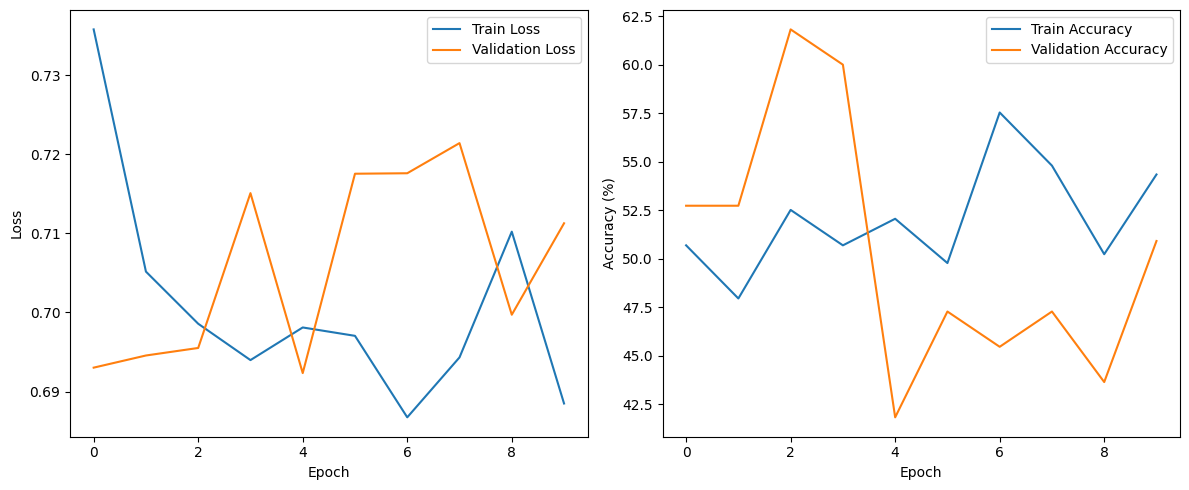

Training complete!
✅ Model saved successfully!


In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import torchaudio
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Configuration
SAMPLE_RATE = 16000
N_MELS = 128
MAX_LENGTH = 500
BATCH_SIZE = 8
EPOCHS = 30  # Increased epochs
LEARNING_RATE = 0.0005  # Adjusted learning rate
WEIGHT_DECAY = 1e-4  # Added weight decay for regularization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Improved Feature Extraction
def extract_features(file_path):
    """Extract multiple audio features for better representation"""
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # 1. Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 2. MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    # 3. Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    # 4. Chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # 5. Tempo and beat features
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    tempo_feature = np.array([[tempo]])
    
    # Pad or truncate to MAX_LENGTH
    def pad_or_truncate(feature, target_length=MAX_LENGTH):
        if feature.shape[1] > target_length:
            return feature[:, :target_length]
        else:
            padding = np.zeros((feature.shape[0], target_length - feature.shape[1]))
            return np.concatenate([feature, padding], axis=1)
    
    mel_spec_db = pad_or_truncate(mel_spec_db)
    mfcc = pad_or_truncate(mfcc)
    contrast = pad_or_truncate(contrast)
    chroma = pad_or_truncate(chroma)
    
    # Stack all features
    features = np.concatenate([
        mel_spec_db,  # (128, MAX_LENGTH)
        mfcc,         # (20, MAX_LENGTH)
        contrast,     # (7, MAX_LENGTH)
        chroma        # (12, MAX_LENGTH)
    ], axis=0)  # (167, MAX_LENGTH)
    
    return features, y, sr

# Data Augmentation
class AudioAugmenter:
    def __init__(self, sr=SAMPLE_RATE):
        self.sr = sr
    
    def time_stretch(self, y, rate=None):
        """Time stretch an audio signal by a fixed rate"""
        if rate is None:
            rate = np.random.uniform(0.8, 1.2)  # Random stretch between 0.8x and 1.2x
        return librosa.effects.time_stretch(y, rate=rate)
    
    def pitch_shift(self, y, steps=None):
        """Pitch shift the audio by n semitones"""
        if steps is None:
            steps = np.random.uniform(-3, 3)  # Random pitch shift between -3 and 3 semitones
        return librosa.effects.pitch_shift(y, sr=self.sr, n_steps=steps)
    
    def add_noise(self, y, noise_factor=None):
        """Add random noise to the audio"""
        if noise_factor is None:
            noise_factor = np.random.uniform(0.001, 0.01)
        noise = np.random.randn(len(y))
        return y + noise_factor * noise
    
    def random_augment(self, y):
        """Apply random augmentations"""
        augmentations = [self.time_stretch, self.pitch_shift, self.add_noise]
        # Apply 0-2 random augmentations
        n_augmentations = np.random.randint(0, 3)
        selected_augmentations = np.random.choice(augmentations, n_augmentations, replace=False)
        
        for augment_fn in selected_augmentations:
            y = augment_fn(y)
        
        return y

# Improved Dataset
class ImprovedStutterDataset(Dataset):
    def __init__(self, features, labels, augment=False):
        self.features = features
        self.labels = labels
        self.augment = augment
        self.augmenter = AudioAugmenter() if augment else None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        return feature, label

# model architecture
class ConformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(ConformerBlock, self).__init__()
        
        # Multihead Self-Attention remains unchanged
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        
        # Convolution module: Replace the initial LayerNorm with BatchNorm1d
        self.conv_module = nn.Sequential(
            nn.BatchNorm1d(d_model),  # Changed from nn.LayerNorm(d_model)
            nn.Conv1d(d_model, d_model * 2, kernel_size=1),
            nn.GLU(dim=1),
            nn.Conv1d(d_model, d_model, kernel_size=3, padding=1, groups=d_model),
            nn.BatchNorm1d(d_model),
            nn.SiLU(),
            nn.Conv1d(d_model, d_model, kernel_size=1),
            nn.Dropout(dropout)
        )
        
        # Feed-forward module remains unchanged
        self.feed_forward = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, dim_feedforward),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        
        # Additional LayerNorms for residual connections
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, attn_mask=None):
        # Self-attention module
        attn_output, _ = self.self_attn(
            self.norm1(x), self.norm1(x), self.norm1(x), 
            attn_mask=attn_mask
        )
        x = x + self.dropout(attn_output)
        
        # Convolution module
        conv_input = x.transpose(1, 2)  # Change shape from (batch, seq_len, d_model) to (batch, d_model, seq_len)
        conv_output = self.conv_module(conv_input).transpose(1, 2)
        x = x + self.dropout(conv_output)
        
        # Feed-forward module
        ff_output = self.feed_forward(self.norm3(x))
        x = x + self.dropout(ff_output)
        
        return x

class ImprovedStutterModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, num_classes, dropout=0.1):
        super(ImprovedStutterModel, self).__init__()
        
        # Initial convolutional feature processing
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        # Calculate dimensions after CNN
        self.cnn_output_features = self._get_cnn_output_features(input_dim)
        
        # Projection layer from CNN to Transformer
        self.projection = nn.Linear(self.cnn_output_features, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Conformer blocks
        self.conformer_blocks = nn.ModuleList([
            ConformerBlock(d_model, nhead, dim_feedforward, dropout) 
            for _ in range(num_layers)
        ])
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def _get_cnn_output_features(self, input_dim):
        # Calculate the CNN output dimensions
        h, w = input_dim, MAX_LENGTH
        h = (h // 2) // 2 // 2  # After 3 max pooling layers with kernel_size=2
        w = (w // 2) // 2 // 2
        return 128 * h  # 128 is the number of channels from the last CNN layer
    
    def forward(self, x):
        # Input shape: (batch_size, features, time_steps)
        batch_size, features, time_steps = x.shape
        
        # Reshape for 2D convolution: (batch, 1, features, time_steps)
        x = x.unsqueeze(1)
        
        # Apply convolutional feature extraction
        x = self.feature_extractor(x)  # Shape: (batch, 128, h/8, w/8)
        
        # Reshape to (batch, sequence_length, features)
        # Consider the reduced time dimension as the sequence length
        seq_len = x.size(3)  # This is w/8 from the CNN output
        x = x.permute(0, 3, 1, 2)  # (batch, w/8, 128, h/8)
        x = x.reshape(batch_size, seq_len, -1)  # (batch, seq_len, 128*h/8)
        
        # Project to transformer dimension
        x = self.projection(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Apply Conformer blocks
        for block in self.conformer_blocks:
            x = block(x)
        
        # Global pooling over sequence dimension
        x = x.mean(dim=1)  # (batch, d_model)
        
        # Apply final classification
        x = self.classifier(x)
        
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

# Training function with improved techniques
def train_improved_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            features = features.float().to(DEVICE)
            labels = labels.long().to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.float().to(DEVICE)
                labels = labels.long().to(DEVICE)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")
        
        # Early stopping with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_improved_stutter_model.pth")
            print("  Model saved!")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:  # Stop if no improvement for 5 epochs
                print("Early stopping triggered!")
                break
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    return model

# Prepare and balance dataset
def prepare_balanced_dataset(folder_path, label_file=None):
    """
    Process all audio files and prepare a balanced dataset
    
    Args:
        folder_path: Path to folder containing .wav files
        label_file: Path to CSV file containing labels (optional)
    
    Returns:
        features and labels as numpy arrays
    """
    wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]
    
    # For demonstration, we'll generate random labels if no label file is provided
    # In a real scenario, you'd load labels from your dataset
    all_features = []
    all_labels = []
    
    print("Processing audio files...")
    for file_path in tqdm(wav_files):
        feature, _, _ = extract_features(file_path)
        all_features.append(feature)
        
        # For demonstration: Assign random labels
        # 0 = no stutter, 1 = stutter
        if label_file is None:
            # Random label for demonstration
            label = np.random.randint(0, 2)
        else:
            # Here you would load the actual label from your label file
            # based on the file name or ID
            file_name = os.path.basename(file_path)
            label = get_label_for_file(file_name, label_file)  # You'd implement this function
            
        all_labels.append(label)
    
    # Balance dataset
    features = np.array(all_features)
    labels = np.array(all_labels)
    
    # Count samples in each class
    class_0_indices = np.where(labels == 0)[0]
    class_1_indices = np.where(labels == 1)[0]
    
    min_class_count = min(len(class_0_indices), len(class_1_indices))
    
    # Randomly sample equal number from each class
    np.random.shuffle(class_0_indices)
    np.random.shuffle(class_1_indices)
    
    balanced_indices = np.concatenate([
        class_0_indices[:min_class_count],
        class_1_indices[:min_class_count]
    ])
    
    np.random.shuffle(balanced_indices)
    
    return features[balanced_indices], labels[balanced_indices]

# Main execution
def main():
    folder_path = r"C:\Users\chidr\OneDrive\Documents\SEMESTER_6\NLP\STUTTER"
    
    # Process all files to get spectrograms and labels
    features, labels = prepare_balanced_dataset(folder_path)
    print(f"Processed {len(features)} audio files")
    
    # Convert to torch tensors
    features_tensor = torch.tensor(features)
    labels_tensor = torch.tensor(labels)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        features_tensor, labels_tensor, test_size=0.2, random_state=42, stratify=labels_tensor
    )
    
    # Create datasets and dataloaders
    train_dataset = ImprovedStutterDataset(X_train, y_train, augment=True)
    val_dataset = ImprovedStutterDataset(X_val, y_val, augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Get input dimensions from the first feature
    input_dim = features[0].shape[0]
    
    # Create improved model
    model = ImprovedStutterModel(
        input_dim=input_dim,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=1024,
        num_classes=2,  # Binary classification: stutter or no stutter
        dropout=0.2
    ).to(DEVICE)
    
    # Define loss function with class weighting to handle imbalance
    criterion = nn.CrossEntropyLoss()
    
    # Use AdamW optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    
    # Train the model
    model = train_improved_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
    )
    
    print("Training complete!")
    return model

if __name__ == "__main__":
    trained_model = main()  # Capture the returned model
    # Save the model weights (state_dict)
    torch.save(trained_model.state_dict(), "best_improved_stutter_model.pth")
    print("✅ Model saved successfully!")

analyzer


In [14]:
import os
import torch
import librosa
import librosa.display  # Required for visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sounddevice as sd
import soundfile as sf
import time
import json
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import torchaudio
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Configuration - should match your training config
SAMPLE_RATE = 16000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Modified feature extraction function
def extract_features(input_data, sr=SAMPLE_RATE):
    """
    Extract multiple audio features for better representation.
    
    Args:
        input_data: Either a file path (str) or a raw audio numpy array.
        sr: Sample rate.
        
    Returns:
        features: Concatenated feature array of shape (167, MAX_LENGTH)
        y: The audio time series used for extraction.
        sr: The sample rate.
    """
    MAX_LENGTH = 500
    N_MELS = 128

    # If input_data is a string, assume it's a file path and load it
    if isinstance(input_data, str):
        y, sr = librosa.load(input_data, sr=sr)
    else:
        y = input_data

    # 1. Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 2. MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    # 3. Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    # 4. Chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Tempo and beat features (not used for stacking)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    
    def pad_or_truncate(feature, target_length=MAX_LENGTH):
        if feature.shape[1] > target_length:
            return feature[:, :target_length]
        else:
            padding = np.zeros((feature.shape[0], target_length - feature.shape[1]))
            return np.concatenate([feature, padding], axis=1)
    
    mel_spec_db = pad_or_truncate(mel_spec_db)
    mfcc = pad_or_truncate(mfcc)
    contrast = pad_or_truncate(contrast)
    chroma = pad_or_truncate(chroma)
    
    # Stack all features: total channels = 128 + 20 + 7 + 12 = 167
    features = np.concatenate([mel_spec_db, mfcc, contrast, chroma], axis=0)
    
    return features, y, sr



DATA AUGMENTATION

In [15]:
# Data Augmentation
class AudioAugmenter:
    def __init__(self, sr=SAMPLE_RATE):
        self.sr = sr
    
    def time_stretch(self, y, rate=None):
        if rate is None:
            rate = np.random.uniform(0.8, 1.2)
        return librosa.effects.time_stretch(y, rate=rate)
    
    def pitch_shift(self, y, steps=None):
        if steps is None:
            steps = np.random.uniform(-3, 3)
        return librosa.effects.pitch_shift(y, sr=self.sr, n_steps=steps)
    
    def add_noise(self, y, noise_factor=None):
        if noise_factor is None:
            noise_factor = np.random.uniform(0.001, 0.01)
        noise = np.random.randn(len(y))
        return y + noise_factor * noise
    
    def random_augment(self, y):
        augmentations = [self.time_stretch, self.pitch_shift, self.add_noise]
        n_augmentations = np.random.randint(0, 3)
        selected_augmentations = np.random.choice(augmentations, n_augmentations, replace=False)
        for augment_fn in selected_augmentations:
            y = augment_fn(y)
        return y



PREP OF DATASET

In [16]:
# Improved Dataset
class ImprovedStutterDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, augment=False):
        self.features = features
        self.labels = labels
        self.augment = augment
        self.augmenter = AudioAugmenter() if augment else None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label




STUTTER ANALYZER

In [17]:
# --- StutterAnalyzer class ---
# Reinitialize the model with the same architecture
model = ImprovedStutterModel(
        input_dim=167,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=1024,
        num_classes=2
).to(torch.device("cpu"))

# Load the weights
model.load_state_dict(torch.load("best_improved_stutter_model.pth", map_location=torch.device("cpu")))

# Set to evaluation mode
model.eval()

class StutterAnalyzer:
    def __init__(self, model_path, threshold=0.5):
        self.threshold = threshold
        self.model = self.load_model(model_path)
        
    def load_model(self, model_path):
        # Import your ImprovedStutterModel from your module
        input_dim = 167  # Should match your feature extraction output (167 channels)
        model = ImprovedStutterModel(
            input_dim=167,
            d_model=256,
            nhead=8,
            num_layers=4,
            dim_feedforward=1024,
            num_classes=2,
            dropout=0.0  # No dropout during inference
        ).to(DEVICE)
        model_path = "best_improved_stutter_model.pth" 
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()
        return model
    
    def segment_audio(self, y, sr, segment_length=3.0, hop_length=0.5):
        segment_samples = int(segment_length * sr)
        hop_samples = int(hop_length * sr)
        segments = []
        timestamps = []
        for i in range(0, len(y) - segment_samples + 1, hop_samples):
            segment = y[i:i + segment_samples]
            segments.append(segment)
            timestamps.append(i / sr)
        return segments, timestamps
    
    def analyze_audio(self, audio_file, return_details=False):
        y, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
        duration = librosa.get_duration(y=y, sr=sr)
        segments, timestamps = self.segment_audio(y, sr)
        
        results = []
        stutter_segments = []
        stutter_confidences = []
        
        for i, (segment, start_time) in enumerate(zip(segments, timestamps)):
            # Process raw audio segments using extract_features
            features, _, _ = extract_features(segment, sr=sr)
            features_tensor = torch.tensor(features).unsqueeze(0).float().to(DEVICE)
            
            with torch.no_grad():
                output = self.model(features_tensor)
                probs = torch.softmax(output, dim=1)
                stutter_prob = probs[0][1].item()
                
                results.append({
                    "segment_id": i,
                    "start_time": start_time,
                    "end_time": min(start_time + 3.0, duration),
                    "stutter_probability": stutter_prob,
                    "has_stutter": stutter_prob > self.threshold
                })
                
                if stutter_prob > self.threshold:
                    stutter_segments.append((start_time, min(start_time + 3.0, duration)))
                    stutter_confidences.append(stutter_prob)
        
        total_segments = len(results)
        stutter_count = sum(1 for r in results if r["has_stutter"])
        stutter_ratio = stutter_count / total_segments if total_segments > 0 else 0
        
        # Merge overlapping stutter segments
        merged_segments = []
        if stutter_segments:
            current_start, current_end = stutter_segments[0]
            current_conf = [stutter_confidences[0]]
            for i in range(1, len(stutter_segments)):
                next_start, next_end = stutter_segments[i]
                if next_start <= current_end:
                    current_end = max(current_end, next_end)
                    current_conf.append(stutter_confidences[i])
                else:
                    avg_conf = sum(current_conf) / len(current_conf)
                    merged_segments.append({
                        "start_time": current_start,
                        "end_time": current_end,
                        "duration": current_end - current_start,
                        "confidence": avg_conf
                    })
                    current_start, current_end = next_start, next_end
                    current_conf = [stutter_confidences[i]]
            avg_conf = sum(current_conf) / len(current_conf)
            merged_segments.append({
                "start_time": current_start,
                "end_time": current_end,
                "duration": current_end - current_start,
                "confidence": avg_conf
            })
        
        total_stutter_duration = sum(seg["duration"] for seg in merged_segments)
        stutter_percentage = (total_stutter_duration / duration) * 100 if duration > 0 else 0
        
        analysis_result = {
            "filename": os.path.basename(audio_file),
            "duration": duration,
            "stutter_ratio": stutter_ratio,
            "stutter_percentage": stutter_percentage,
            "total_stutter_duration": total_stutter_duration,
            "stutter_segments": merged_segments,
            "speech_fluency_score": 100 - stutter_percentage,
        }
        
        if return_details:
            analysis_result["detailed_segments"] = results
        
        return analysis_result
    
    def visualize_results(self, audio_file, analysis_result):
        y, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
        duration = librosa.get_duration(y=y, sr=sr)
        
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.6)
        plt.title(f'Audio Waveform with Stutter Detection - "{os.path.basename(audio_file)}"')
        for segment in analysis_result["stutter_segments"]:
            start = segment["start_time"]
            end = segment["end_time"]
            confidence = segment["confidence"]
            alpha = min(0.8, max(0.3, confidence))
            plt.axvspan(start, end, color='red', alpha=alpha)
            plt.text(start, 0, f"{confidence:.2f}", fontsize=8, color='black')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        plt.subplot(2, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        for segment in analysis_result["stutter_segments"]:
            start = segment["start_time"]
            end = segment["end_time"]
            plt.axvspan(start, end, color='red', alpha=0.3)
        plt.title('Spectrogram with Stutter Regions')
        plt.tight_layout()
        
        output_dir = os.path.dirname(audio_file)
        output_file = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(audio_file))[0]}_analysis.png")
        plt.savefig(output_file, dpi=300)
        plt.show()
        return output_file
    
    def generate_report(self, audio_file, analysis_result, include_visualization=True):
        report = {
            "filename": analysis_result["filename"],
            "duration": analysis_result["duration"],
            "stutter_ratio": analysis_result["stutter_ratio"],
            "stutter_percentage": analysis_result["stutter_percentage"],
            "total_stutter_duration": analysis_result["total_stutter_duration"],
            "speech_fluency_score": analysis_result["speech_fluency_score"],
            "stutter_segments": analysis_result["stutter_segments"],
        }
        if include_visualization:
            vis_path = self.visualize_results(audio_file, analysis_result)
            report["visualization"] = vis_path
        
        # Save report to JSON file
        report_path = os.path.join(os.path.dirname(audio_file), f"{os.path.splitext(os.path.basename(audio_file))[0]}_report.json")
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4)
        return report_path

def save_model(self, save_path="stutter_analyzer.pth"):
    torch.save({
        'model_state_dict': self.model.state_dict(),
        'threshold': self.threshold
    }, save_path)
    print(f"Model saved to {save_path}")

def load_model(self, model_path):
    from stutter_model import ImprovedStutterModel  # Ensure this is correct
    
    input_dim = 167  # Should match feature extraction output
    model = ImprovedStutterModel(
        input_dim=input_dim,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=1024,
        num_classes=2,
        dropout=0.0
    ).to(DEVICE)
    
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    self.threshold = checkpoint.get('threshold', 0.5)  # Load threshold if available
    model.eval()
    return model

analyzer = StutterAnalyzer(model_path="best_improved_stutter_model.pth")
result = analyzer.analyze_audio(r"C:\Users\chidr\OneDrive\Documents\SEMESTER_6\NLP\STUTTER\M_1216_11y1m_1.wav", return_details=True)
from pprint import pprint
pprint(result)




{'detailed_segments': [{'end_time': 3.0,
                        'has_stutter': True,
                        'segment_id': 0,
                        'start_time': 0.0,
                        'stutter_probability': 0.6793785095214844},
                       {'end_time': 3.5,
                        'has_stutter': True,
                        'segment_id': 1,
                        'start_time': 0.5,
                        'stutter_probability': 0.6801303625106812},
                       {'end_time': 4.0,
                        'has_stutter': True,
                        'segment_id': 2,
                        'start_time': 1.0,
                        'stutter_probability': 0.6770637035369873},
                       {'end_time': 4.5,
                        'has_stutter': True,
                        'segment_id': 3,
                        'start_time': 1.5,
                        'stutter_probability': 0.6813444495201111},
                       {'end_time': 5.0,
       

In [59]:
# --- StutterAnalyzer class ---
# Reinitialize the model with the same architecture
model = ImprovedStutterModel(
        input_dim=167,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=1024,
        num_classes=2
).to(torch.device("cpu"))

# Load the weights
model.load_state_dict(torch.load("best_improved_stutter_model.pth", map_location=torch.device("cpu")))

# Set to evaluation mode
model.eval()

class StutterAnalyzer:
    def __init__(self, model_path, threshold=0.5):
        self.threshold = threshold
        self.model = self.load_model(model_path)
        
    def load_model(self, model_path):
        # Import your ImprovedStutterModel from your module
        input_dim = 167  # Should match your feature extraction output (167 channels)
        model = ImprovedStutterModel(
            input_dim=167,
            d_model=256,
            nhead=8,
            num_layers=4,
            dim_feedforward=1024,
            num_classes=2,
            dropout=0.0  # No dropout during inference
        ).to(DEVICE)
        model_path = "best_improved_stutter_model.pth" 
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()
        return model
    
    def segment_audio(self, y, sr, segment_length=3.0, hop_length=0.5):
        segment_samples = int(segment_length * sr)
        hop_samples = int(hop_length * sr)
        segments = []
        timestamps = []
        for i in range(0, len(y) - segment_samples + 1, hop_samples):
            segment = y[i:i + segment_samples]
            segments.append(segment)
            timestamps.append(i / sr)
        return segments, timestamps
    
    def analyze_audio(self, audio_file, return_details=False):
        y, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
        duration = librosa.get_duration(y=y, sr=sr)
        segments, timestamps = self.segment_audio(y, sr)
        
        results = []
        stutter_segments = []
        stutter_confidences = []
        
        for i, (segment, start_time) in enumerate(zip(segments, timestamps)):
            # Process raw audio segments using extract_features
            features, _, _ = extract_features(segment, sr=sr)
            features_tensor = torch.tensor(features).unsqueeze(0).float().to(DEVICE)
            
            with torch.no_grad():
                output = self.model(features_tensor)
                probs = torch.softmax(output, dim=1)
                stutter_prob = probs[0][1].item()
                
                results.append({
                    "segment_id": i,
                    "start_time": start_time,
                    "end_time": min(start_time + 3.0, duration),
                    "stutter_probability": stutter_prob,
                    "has_stutter": stutter_prob > self.threshold
                })
                
                if stutter_prob > self.threshold:
                    stutter_segments.append((start_time, min(start_time + 3.0, duration)))
                    stutter_confidences.append(stutter_prob)
        
        total_segments = len(results)
        stutter_count = sum(1 for r in results if r["has_stutter"])
        stutter_ratio = stutter_count / total_segments if total_segments > 0 else 0
        
        # Merge overlapping stutter segments
        merged_segments = []
        if stutter_segments:
            current_start, current_end = stutter_segments[0]
            current_conf = [stutter_confidences[0]]
            for i in range(1, len(stutter_segments)):
                next_start, next_end = stutter_segments[i]
                if next_start <= current_end:
                    current_end = max(current_end, next_end)
                    current_conf.append(stutter_confidences[i])
                else:
                    avg_conf = sum(current_conf) / len(current_conf)
                    merged_segments.append({
                        "start_time": current_start,
                        "end_time": current_end,
                        "duration": current_end - current_start,
                        "confidence": avg_conf
                    })
                    current_start, current_end = next_start, next_end
                    current_conf = [stutter_confidences[i]]
            avg_conf = sum(current_conf) / len(current_conf)
            merged_segments.append({
                "start_time": current_start,
                "end_time": current_end,
                "duration": current_end - current_start,
                "confidence": avg_conf
            })
        
        total_stutter_duration = sum(seg["duration"] for seg in merged_segments)
        stutter_percentage = (total_stutter_duration / duration) * 100 if duration > 0 else 0
        
        analysis_result = {
            "filename": os.path.basename(audio_file),
            "duration": duration,
            "stutter_ratio": stutter_ratio,
            "stutter_percentage": stutter_percentage,
            "total_stutter_duration": total_stutter_duration,
            "stutter_segments": merged_segments,
            "speech_fluency_score": 100 - stutter_percentage,
        }
        
        if return_details:
            analysis_result["detailed_segments"] = results
        
        return analysis_result
    
    def visualize_results(self, audio_file, analysis_result):
        y, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
        duration = librosa.get_duration(y=y, sr=sr)
        
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.6)
        plt.title(f'Audio Waveform with Stutter Detection - "{os.path.basename(audio_file)}"')
        for segment in analysis_result["stutter_segments"]:
            start = segment["start_time"]
            end = segment["end_time"]
            confidence = segment["confidence"]
            alpha = min(0.8, max(0.3, confidence))
            plt.axvspan(start, end, color='red', alpha=alpha)
            plt.text(start, 0, f"{confidence:.2f}", fontsize=8, color='black')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        plt.subplot(2, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        for segment in analysis_result["stutter_segments"]:
            start = segment["start_time"]
            end = segment["end_time"]
            plt.axvspan(start, end, color='red', alpha=0.3)
        plt.title('Spectrogram with Stutter Regions')
        plt.tight_layout()
        
        output_dir = os.path.dirname(audio_file)
        output_file = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(audio_file))[0]}_analysis.png")
        plt.savefig(output_file, dpi=300)
        plt.show()
        return output_file
    
    def generate_report(self, audio_file, analysis_result, include_visualization=True):
        report = {
            "filename": analysis_result["filename"],
            "duration": analysis_result["duration"],
            "stutter_ratio": analysis_result["stutter_ratio"],
            "stutter_percentage": analysis_result["stutter_percentage"],
            "total_stutter_duration": analysis_result["total_stutter_duration"],
            "speech_fluency_score": analysis_result["speech_fluency_score"],
            "stutter_segments": analysis_result["stutter_segments"],
        }
        if include_visualization:
            vis_path = self.visualize_results(audio_file, analysis_result)
            report["visualization"] = vis_path
        
        # Save report to JSON file
        report_path = os.path.join(os.path.dirname(audio_file), f"{os.path.splitext(os.path.basename(audio_file))[0]}_report.json")
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=4)
        return report_path

def save_model(self, save_path="stutter_analyzer.pth"):
    torch.save({
        'model_state_dict': self.model.state_dict(),
        'threshold': self.threshold
    }, save_path)
    print(f"Model saved to {save_path}")

def load_model(self, model_path):
    from stutter_model import ImprovedStutterModel  # Ensure this is correct
    
    input_dim = 167  # Should match feature extraction output
    model = ImprovedStutterModel(
        input_dim=input_dim,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=1024,
        num_classes=2,
        dropout=0.0
    ).to(DEVICE)
    
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    self.threshold = checkpoint.get('threshold', 0.5)  # Load threshold if available
    model.eval()
    return model

analyzer = StutterAnalyzer(model_path="best_improved_stutter_model.pth")
result = analyzer.analyze_audio(r"C:\Users\chidr\OneDrive\Documents\SEMESTER_6\NLP\output\trial.wav", return_details=True)
from pprint import pprint
pprint(result)




{'detailed_segments': [{'end_time': 3.0,
                        'has_stutter': True,
                        'segment_id': 0,
                        'start_time': 0.0,
                        'stutter_probability': 0.6838591694831848},
                       {'end_time': 3.5,
                        'has_stutter': True,
                        'segment_id': 1,
                        'start_time': 0.5,
                        'stutter_probability': 0.6842693090438843},
                       {'end_time': 4.0,
                        'has_stutter': True,
                        'segment_id': 2,
                        'start_time': 1.0,
                        'stutter_probability': 0.684306263923645},
                       {'end_time': 4.5,
                        'has_stutter': True,
                        'segment_id': 3,
                        'start_time': 1.5,
                        'stutter_probability': 0.684421956539154}],
 'duration': 4.864,
 'filename': 'trial.wav',
 's

In [ ]:
analyzer.stop_analysis()

Analysis stopped


In [61]:
import imageio_ffmpeg
import subprocess
import os
import tempfile
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def mp4_to_wav(mp4_path, output_dir="output"):
    """Convert MP4 to WAV using FFmpeg with better error handling"""
    try:
        # Validate input
        if not os.path.isfile(mp4_path):
            raise FileNotFoundError(f"Input file not found: {mp4_path}")
            
        # Get FFmpeg binary
        ffmpeg_exe = imageio_ffmpeg.get_ffmpeg_exe()
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Create temp file (safer for concurrent operations)
        base_name = os.path.splitext(os.path.basename(mp4_path))[0]
        wav_path = os.path.join(output_dir, f"{base_name}.wav")
        
        # FFmpeg command with improved parameters
        cmd = [
            ffmpeg_exe,
            '-hide_banner',  # Cleaner output
            '-loglevel', 'error',  # Only show errors
            '-i', mp4_path,
            '-vn',
            '-acodec', 'pcm_s16le',
            '-ar', '16000',  # Must match your model's expected sample rate
            '-ac', '1',      # Mono conversion
            '-y',            # Overwrite output
            '-f', 'wav',     # Explicit output format
            wav_path
        ]
        
        # Run conversion with timeout
        result = subprocess.run(
            cmd,
            check=True,
            capture_output=True,
            timeout=30  # 30-second timeout
        )
        
        # Verify output
        if not os.path.exists(wav_path):
            raise RuntimeError("Conversion failed: No output file created")
            
        if os.path.getsize(wav_path) == 0:
            os.remove(wav_path)
            raise RuntimeError("Conversion failed: Empty output file")
            
        logger.info(f"Successfully converted to {wav_path}")
        return wav_path
        
    except Exception as e:
        logger.error(f"Conversion failed: {str(e)}")
        # Clean up partial files
        if 'wav_path' in locals() and os.path.exists(wav_path):
            os.remove(wav_path)
        return None

def analyze_video(video_path, keep_audio=False):
    """Analyze video with safety improvements"""
    try:
        # Convert to WAV
        wav_file = mp4_to_wav(video_path)
        if not wav_file:
            return None
            
        # Initialize analyzer once (more efficient)
        analyzer = StutterAnalyzer("best_improved_stutter_model.pth")
        
        # Analyze with error handling
        results = analyzer.analyze_audio(wav_file)
        
        # Optional cleanup
        if not keep_audio:
            os.remove(wav_file)
            logger.info(f"Cleaned up temporary audio: {wav_file}")
            
        return results
        
    except Exception as e:
        logger.error(f"Analysis failed: {str(e)}")
        # Ensure cleanup even on failure
        if 'wav_file' in locals() and os.path.exists(wav_file) and not keep_audio:
            os.remove(wav_file)
        return None

In [55]:
def test_conversion():
    # Test with a sample MP4 file
    input_video = "trial.mp4"  # Replace with your test file
    output_wav = mp4_to_wav(input_video)
    
    if output_wav:
        print(f"Conversion successful! Output: {output_wav}")
        print(f"File exists: {os.path.exists(output_wav)}")
        print(f"File size: {os.path.getsize(output_wav)} bytes")
    else:
        print("Conversion failed")

if __name__ == "__main__":
    test_conversion()

INFO:__main__:Successfully converted to output\trial.wav


Conversion successful! Output: output\trial.wav
File exists: True
File size: 155726 bytes


In [57]:
def check_audio(wav_path):
    try:
        import wave
        with wave.open(wav_path, 'rb') as wf:
            frames = wf.getnframes()
            rate = wf.getframerate()
            duration = frames / float(rate)
            print(f"Audio duration: {duration:.2f} seconds")
            
        # Play audio (requires sounddevice)
        import sounddevice as sd
        data, sr = sf.read(wav_path)
        sd.play(data, sr)
        sd.wait()
        
    except Exception as e:
        print(f"Audio check failed: {str(e)}")

check_audio("output/trial.wav")

Audio duration: 4.86 seconds
